# Classification Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

Team CB3, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).


![alt text here](https://co2cards.com/wp-content/uploads/climate-change-0-787x340.jpg)

### Predict Overview: 


"Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

Our purpose with this predict is to develop a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

This will assist companies with a broader view of customer believes, assisting companies with future marketing strategies."


<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

<a href=#seven>8. Test For Kaggle</a>

<a href=#seven>9. Web APP</a>

<a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>


Import numpy to assist with data calculations
Import pandas to import data and manipulate the data
Import matplotlib and seaborn for visualisation

In [24]:
import pandas as pd
import nltk
import numpy as np

#Ignore warnings for a cleaner notebook
import warnings
warnings.filterwarnings('ignore')

#Data Engineering
import re
from nltk.corpus import stopwords
#nltk.download(['punkt', 'stopwords'])
import string

#Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Comet commands
from comet_ml import Experiment


<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


Load train and test data into dataframes

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test_with_no_labels.csv')

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Add explanation

In [34]:
df.head(20)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954
5,1,Worth a read whether you do or don't believe i...,425577
6,1,RT @thenation: Mike Pence doesn’t believe in g...,294933
7,1,RT @makeandmendlife: Six big things we can ALL...,992717
8,1,@AceofSpadesHQ My 8yo nephew is inconsolable. ...,664510
9,1,RT @paigetweedy: no offense… but like… how do ...,260471


In [4]:
df.shape

(15819, 3)

In [11]:
#Investigate number per category - sentiment
df.groupby('sentiment').describe()

tweetid                                                             \
            count           mean            std     min        25%       50%   
sentiment                                                                      
-1         1296.0  499169.447531  289509.003781  1422.0  243479.25  494572.0   
 0         2353.0  496550.249894  286519.834520   229.0  250733.00  483496.0   
 1         8530.0  507418.550762  289537.581404     6.0  257622.75  511867.5   
 2         3640.0  492613.500275  289163.550697    86.0  246628.25  490980.0   

                                
                 75%       max  
sentiment                       
-1         759714.75  999537.0  
 0         734897.00  999888.0  
 1         761983.50  999698.0  
 2         738188.50  999236.0

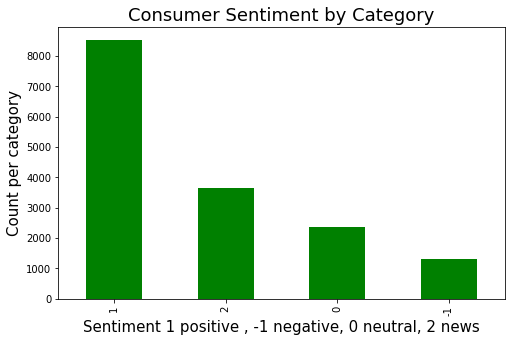

In [16]:
#Graph of consumer sentiment
df['sentiment'].value_counts().plot(kind = 'bar', color = 'green', figsize =(8,5))
plt.title("Consumer Sentiment by Category", fontsize =18)
plt.xlabel("Sentiment 1 positive , -1 negative, 0 neutral, 2 news", fontsize=15)
plt.ylabel("Count per category", fontsize = 15)
plt.show()

**Class Description**
Data consists of 15 819 records, consisting of:
* News(2): the tweet links to factual news about climate change - 3 640 records
* Pro(1): the tweet supports the belief of man-made climate change - 8 530 records
* Neutral(0): the tweet neither supports nor refutes the belief of man-made climate change - 2 353 records
* Anti(-1): the tweet does not believe in man-made climate change - 1 296 records

In [20]:
#Check for null values
df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [25]:
#check for any outliers - kurtosis score of more than 3 indicates high outliers 
df.kurtosis()

sentiment    0.122976
tweetid     -1.193356
dtype: float64

We do not have a score of more than 3 indicating we do not have high outliers

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [4]:
#Make a copy of dataframe to start engineering phase
df_tweet = df.copy()

In [5]:
#remove Line breaks
df_tweet = df_tweet.replace('\n', ' ')

In [6]:
#Change all words in message to lower case and remove punctuations
def remove_punctuation(words):
    words = words.lower()
    return ''.join([x for x in words if x not in string.punctuation])

In [7]:
df_tweet['message'] = df_tweet['message'].apply(remove_punctuation)

In [8]:
#Remove all URL's and replace them with url-web
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df_tweet['message'] = df_tweet['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)


In [11]:
#Remove stopwords
df_tweet = [t for t in df_tweet['message'] if t not in stopwords.words('english')]

In [35]:
# Lammitize or stem all words 
# deal with @ signs and hashtags
#bag of words
#drop tweet Id column


<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="seven"></a>
## 8. Test For Kaggle
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="seven"></a>
## 9. Web APP
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [ ]:
# #Create an experiment with api key
# experiment = Experiment(
#     api_key ="",
#     project_name = "Classification_Predict",
#     workspace = "alnaschutte",
# )

In [ ]:
#python train.py